# Piano.io Assessment Submission
Author: Sarvesh Shah, sarveshshah00@gmail.com, sarvesh-shah.com

## Question 1:

```SQL
SELECT
    CASE 
        when parsedReferrerId = 0 then 'google'
        when parsedReferrerId = 2 then 'facebook'
        when parsedReferrerId = 3 then 'internal'
        when parsedReferrerId = 11 then 'google'
        when parsedReferrerId = 12 then 'other'
        when parsedReferrerId = 13 then 'direct'
    END AS parsedReferrer,
    COUNT(pageviewID) as pageviews
FROM
    `Screening_Questions.pageviews`  as A
GROUP BY
  parsedReferrer
ORDER BY
  pageviews DESC
```

## Question 2:

```SQL
SELECT
    visitID,
    CASE 
        when parsedReferrerId = 0 then 'google'
        when parsedReferrerId = 2 then 'facebook'
        when parsedReferrerId = 3 then 'internal'
        when parsedReferrerId = 11 then 'google'
        when parsedReferrerId = 12 then 'other'
        when parsedReferrerId = 13 then 'direct'
    END AS `first_referrer`
FROM   
     `piano-public.Screening_Questions.pageviews`  as A
WHERE
    unixTimestamp = (
        SELECT 
            MIN(unixTimestamp)
        FROM 
            `piano-public.Screening_Questions.pageviews` AS B
        WHERE
            A.visitID = B.visitID
    )
ORDER BY
    visitID
```

## Question 3

For question 3, I chose to download the data and do my analysis in Python using a jupyter notebook

### Area of exploration:
<br>• Platforms seem more interesting because website layout and interaction changes with platforms. 
<br>• Referrer was another interesting area to look at.
<br>• Any time series analysis was not an option as the data was for only 1 day.
<br>• Location seemed a bit interesting to look into, though did not seem as promising.
<br>• Operating Systems did not seem as interesting considering it is a website. 
<br>• Similarly, Browsers were not as appealing either.

### Data Cleaning

In [18]:
# import statements

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import datetime as dt

df = pd.read_csv('Downloads/results-20200622-111148.csv')

df['unixTimestamp'] = pd.to_datetime(df['unixTimestamp'])
df['hour_of_day'] = df['unixTimestamp'].dt.hour

# Adding ParsedReferrer
d = { 
0:'google',
2:'facebook',
3:'twitter',
11:'internal',
12:'other',
13:'direct'
}

df['parsedReferrer'] = ''
for key,val in d.items():
    df['parsedReferrer'] = np.where(df['parsedReferrerId']==key,'{}'.format(val),df['parsedReferrer'])
    
print(df.isna().sum())
    
fill_value = {'country':'Unknown','region':'Unknown'}
df = df.dropna(subset=['visitID']).fillna(fill_value)

pageviewID             0
unixTimestamp          0
browserID              0
visitID               16
country               60
region              1270
platform               0
operatingSystem        0
browser                0
parsedReferrerId       0
hour_of_day            0
parsedReferrer         0
dtype: int64


### Defining loyal users 

We defined loyal users as having at least 5-page visit for a given visit ID and directly coming to website. Decided to go for this additional constraint as the website is very appealing and most users seem to have 1-5 visits per session, but if a user directly comes to the website and explore over five pages, we can be very certain that they are loyal users.

<p>
Thus we assume each visit_id as a user and if they have more than certain number of pageviews we categorize them as "loyal user".
In addition to the frequency, we calculate the 'firstVisit' as the firstReferrer used to visit the website, if the first visit is "direct" then it is likely that the user is aware of the website and if they view more than "x" number of pages while coming directly to our website is a strong signal for a loyal user. Based on histogram we can see that most visit only have less than 5 pageviews and thus we assume anyone over 5 pageviews to be termed as a loyal_user.
    
This is just an assumption and in practice might not work as much but due to limited nature of data points, we shall use this definition for this analysis
    
**Loyal User = Any user that directly comes to the website and views more than 5 pages in that visit**
</p>

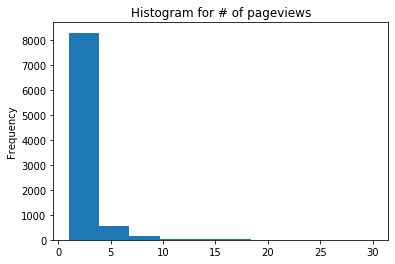

In [19]:
df['visitID'].value_counts().plot(kind='hist', title='Histogram for # of pageviews')

**Note:** We formalize our assumption as follows because we only have data for a day and we do not have a user-id to identify if a new session was instantiated by a same user or not thus cannot do a more complex assumption. If we could track the returning users and or look at number of returns in a given time frame, that could result in a much better definition.

<p>
<b>A user is as a loyal user if:</b>
<br><\t>    1.	They are returning user
<br><\t>    2.	number of visits per month for that user > threshold 
<br><\t>    3.	Spend at least a certain amount of active-time on the site in a given session
<br><i>*Threshold can be a function of the distribution we have for # of visits. 


In [22]:
# Loyal User Code

# We use the timestamp to identify the first referrer similar to what we did for Question 2 in BigQuery
temp = df.groupby(['visitID'])[['unixTimestamp']].min().reset_index()
temp['firstVisit'] = True
df = df.merge(temp, on=['visitID','unixTimestamp'], how='left').fillna(False)

# We categorize 'Frequent Visitor' as # of visits > 5
temp = pd.DataFrame(df['visitID'].value_counts())
temp['user_type'] = np.where(temp['visitID']>5,'frequent_visitor','not_frequent_visitor')
temp = temp.reset_index()

df = df.merge(temp, left_on='visitID', right_on='index').drop(columns= ['index','visitID_y']).rename(columns={'visitID_x':'visitID'})

df['loyal_user'] = np.where((df.firstVisit==True)&(df.parsedReferrer=='direct')&(df['user_type']=='frequent_visitor'),True,False)

print('Non Loyal Users: {}\nLoyal Users: {}'.format(df.loyal_user.value_counts()[0],df.loyal_user.value_counts()[1]))

Non Loyal Users: 15748
Loyal Users: 236


### Breaking down data to see any interesting difference between groups

#### 1. Platform of Choice
One interesting observation was that the loyal users largely used desktop. Whereas for non-loyal users we had significant traffic coming from mobile. We performed a t-test to statistically determine the significance. 

,visitID
platform,
desktop,92.796610
mobile,5.508475
tablet,1.694915


,visitID
platform,
desktop,72.072644
mobile,21.367793
tablet,4.254509
bot,2.228854
other,0.076200


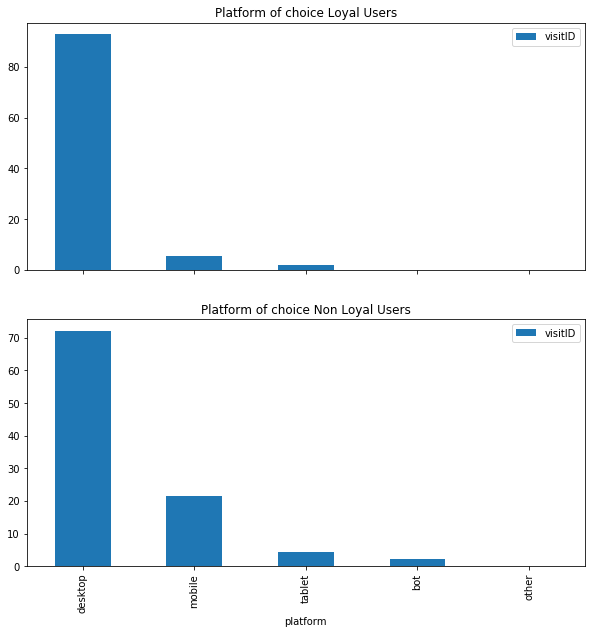

In [9]:
df1 = df.groupby(['loyal_user','platform'])[['visitID']].count()
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(10,10))

(df1.loc[True].sort_values(by='visitID',ascending=False)*100/(df1.loc[True].sum())).plot(kind='bar',ax=axes[0],title='Platform of choice Loyal Users')
(df1.loc[False].sort_values(by='visitID',ascending=False)*100/(df1.loc[False].sum())).plot(kind='bar',ax=axes[1],title='Platform of choice Non Loyal Users')

display(df1.loc[True].sort_values(by='visitID',ascending=False)*100/(df1.loc[True].sum()))
display(df1.loc[False].sort_values(by='visitID',ascending=False)*100/(df1.loc[False].sum()))

We can see from the chart that out 92.78% of our loyal users browse the site via the website, whereas the traffic for with mobile playform is about 5%/, the non-loyal users on the other had tend to use our website 21% of the time. 

In [10]:
# T-test
n1 = float(df1.loc[True].sum())
n2 = float(df1.loc[False].sum())

p1 = float(df1.loc[True, 'mobile']/n1)
p2 = float(df1.loc[False, 'mobile']/n2)

q1 = 1-p1
q2 = 1-p2

print('p1=',p1,'\np2=',p2,'\nq1=',q1,'\nq2=',q2,'\nn1=',n1,'\nn2=',n2)

t = (p1 - p2) / math.sqrt((p1*q1/n1)+(p2*q2/n2))
print('\nT-score:',t)

if t>=1.96 or t<=-1.96:
    print('\nP-value p < 0.05, Significant')
else:
    print('\nP-value p > 0.05, Not Significant')

p1= 0.05508474576271186 
p2= 0.21367792735585472 
q1= 0.9449152542372882 
q2= 0.7863220726441453 
n1= 236.0 
n2= 15748.0

T-score: -10.429657455664366

P-value p < 0.05, Significant


One intuition was that most of the ad-based traffic comes from social media and people tend to use social media more on the phone. This was further corroborated by the fact that traffic coming from google was higher on desktop.

We look at the non_loyal users who use mobile platform and compare it to desktop users who use the platform. We can see that social media (Facebook, Twitter) drives the significant amount of traffic (14%) on phones compared to desktop (1%), whereas google seems to drive 9.2 % point more traffic on desktop.

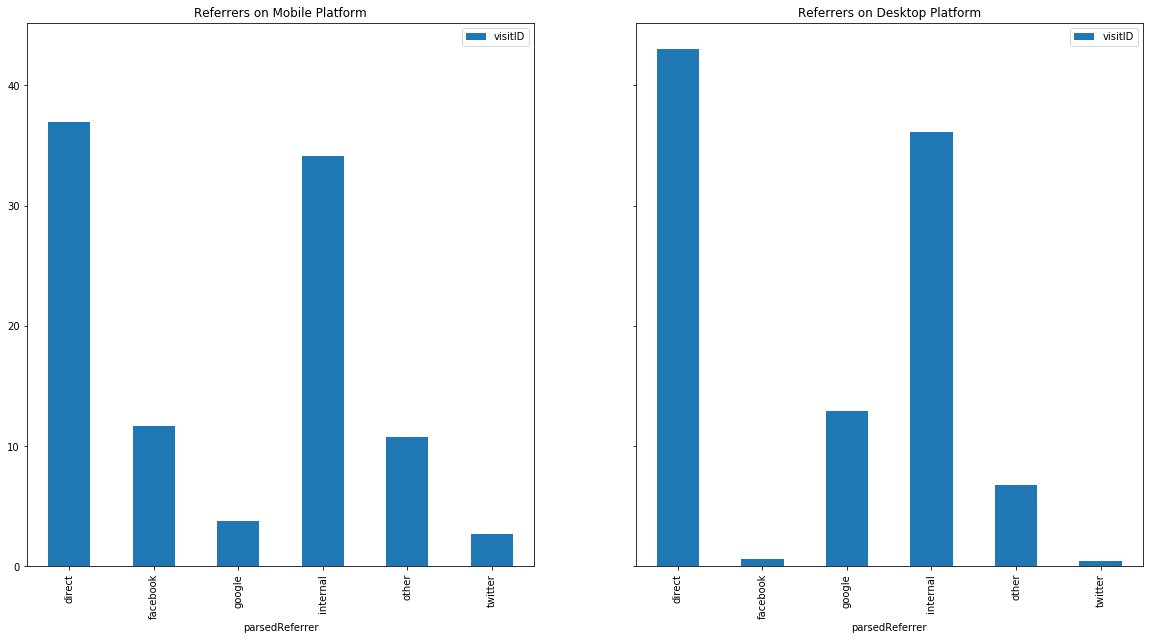

In [11]:
fig, axes = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(10*2,10))

(df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[False,'mobile']*100/df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[False,'mobile'].sum()).plot(kind='bar',ax=axes[0],title='Referrers on Mobile Platform')
(df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[False,'desktop']*100/df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[False,'desktop'].sum()).plot(kind='bar',ax=axes[1], title='Referrers on Desktop Platform')

In [12]:
display(df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[False,'mobile']*100/df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[False,'mobile'].sum())
display(df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[False,'desktop']*100/df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[False,'desktop'].sum())

,visitID
parsedReferrer,
direct,36.968796
facebook,11.679049
google,3.744428
internal,34.145617
other,10.728083
twitter,2.734027


,visitID
parsedReferrer,
direct,43.057269
facebook,0.599119
google,12.951542
internal,36.123348
other,6.810573
twitter,0.458150


Comparring to loyal customers, which we have assumed to directly access the website show that people generally do not prefer to access the site on phone if they know about it. This is a biased assumption and I believe that this is not true, but we still reach this conclusion.

,,visitID
platform,parsedReferrer,
desktop,direct,92.796610
mobile,direct,5.508475
tablet,direct,1.694915


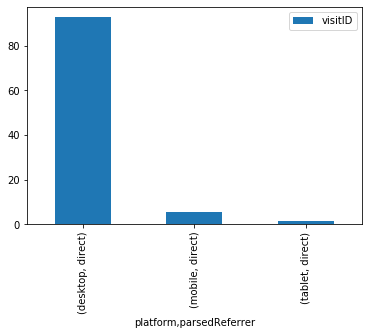

In [13]:
display(df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[True]*100/df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[True].sum())
(df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[True]*100/df.groupby(['loyal_user','platform','parsedReferrer'])[['visitID']].count().loc[True].sum()).plot(kind='bar')

Thus, we can assume that our ads are working well and considerable amounts of people are visiting the website because of these ads. 
In addition, the loyal consumers primarily use Desktop to view there Piano dashboards. This appears to be an untapped demographic. This sets up precedent to do some market research and determine if there is a market for an app which might be more convenient  for users who are ‘on the go’ to use phone than wait for a desktop. Perhaps we can divert our resources on an easy-to-use app to drive more traffic.


#### 2. Looking at some hourly trends

Since we are limited to only 1-day of data, I decided to calculate ‘hour-of-the-day’ metric. I looked at the distribution for # of visits for loyal and non-loyal users. We see that there are more defined peaks for the hour of the day for loyal users compared to non-loyal users. Although it is interesting to note that, the trends are similar for both the groups. 

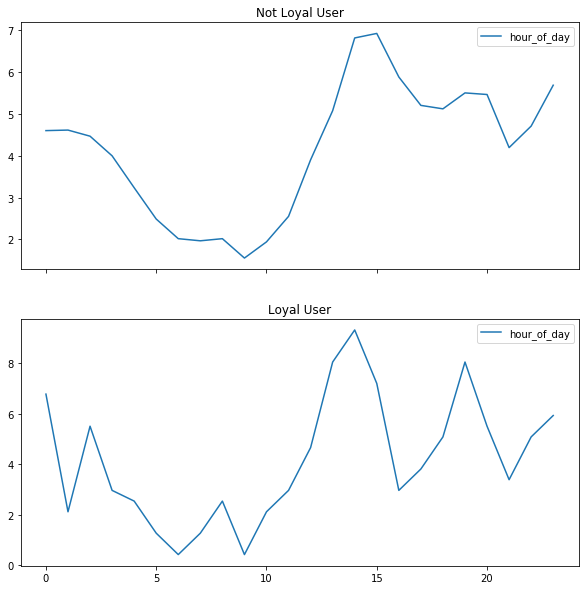

In [14]:
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(10,10))

pd.DataFrame(df[df.loyal_user!=True]['hour_of_day'].value_counts()*100/df[df.loyal_user!=True]['hour_of_day'].value_counts().sum()).sort_index().plot(title='Not Loyal User',ax=axes[0])
pd.DataFrame(df[df.loyal_user==True]['hour_of_day'].value_counts()*100/df[df.loyal_user==True]['hour_of_day'].value_counts().sum()).sort_index().plot(title='Loyal User',ax=axes[1])

### 3. Location Trend

Looking at the time trend, the varitation was very consistent which led me to believe that our clients are most likely saturated in a single timezone, or more active usage comes from few countries located in a vicinity. This was verified by the data as we can see that in case of both Loyal and Non-Loyal users more than 75% of our traffic comes from US and regional breakdown indicates that most of these users are in CA and NY 

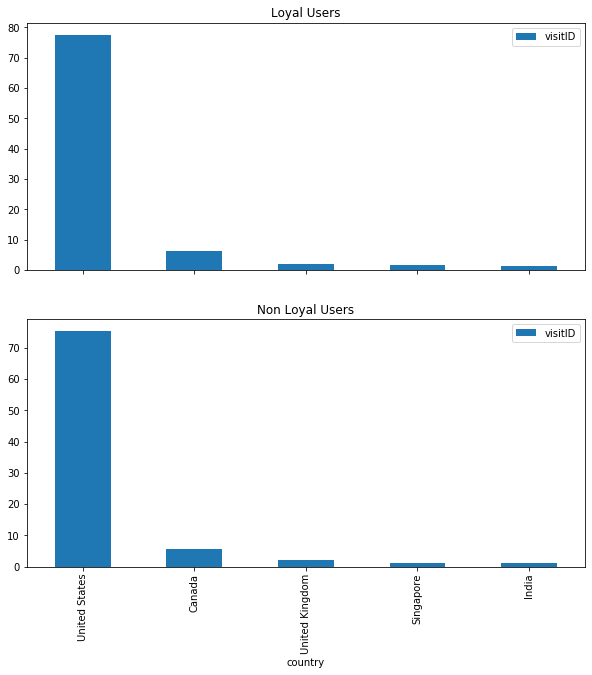

In [23]:
df1 = df.groupby(['loyal_user','country'])[['visitID']].count()
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(10,10))

(df1.loc[True].sort_values(by='visitID',ascending=False)*100/(df1.loc[True].sum())).head(5).plot(kind='bar',ax=axes[0], title='Loyal Users')
(df1.loc[False].sort_values(by='visitID',ascending=False)*100/(df1.loc[False].sum())).head(5).plot(kind='bar',ax=axes[1], title='Non Loyal Users')

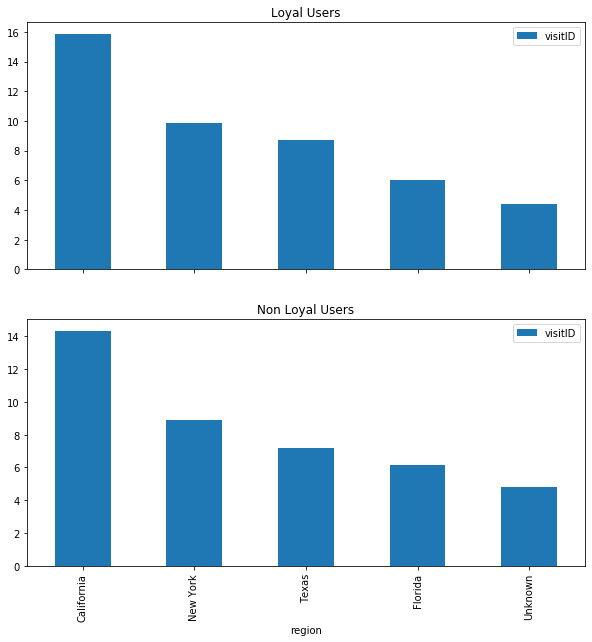

In [24]:
df1 = df[df.country=='United States'].groupby(['loyal_user','region'])[['visitID']].count()

fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(10,10))

(df1.loc[True].sort_values(by='visitID',ascending=False)*100/(df1.loc[True].sum())).head(5).plot(kind='bar',ax=axes[0],title='Loyal Users')
(df1.loc[False].sort_values(by='visitID',ascending=False)*100/(df1.loc[False].sum())).head(5).plot(kind='bar',ax=axes[1],title='Non Loyal Users')